A notebook to compare drift skill in CIOPS-W and SalishSea.

Runs:
* CIOPS-W DI04 hourly
* SalishSeaN08 hourly (mislabelled as N01). This was run with Susan's winds
* SalishSeaP01 hourly. This was run with blended mshydro winds.

All drift predicitons used Open Drift with 2% winds from mshydro. Model drifters were released every 6 hours for a 48 hour duration.

Drifters are 2016 SCTs released by IOS. Grounded drifters were removed manually. 

Bootstrapping techniques for error analysis and variability. 

In [1]:
import glob
import os

import datetime
from matplotlib.pyplot import cm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import shapely
import xarray as xr
import yaml


%matplotlib inline

In [2]:
comparison_data='/home/soontiensn/data/gpsc-jeh326/sample_model_outputs/cropped_datasets/SalishN01-SalishP01-CIOPSWhourly/'

# Binning functions
We really need to get these functions into the drift tool so that they can be imported rather than copied.

In [8]:
def custom_resampler(array_like):
    return list(array_like)

In [55]:
def bin_skills_individual_drifter(ds, skill):
    """Bin the skill score for an individual drifter in hourly bins.
    
    Parameters
    ----------
    ds : xarray.Dataset
        The dataset which contains data to be averaged.
        
    skill : str
        The skill to be binned (e.g. sep, molcard, etc).
        
    Returns
    -------.
    all_tracks : pandas.DataFrame
        A data frame that contains the list of scores in each hourly bin
    """
    all_tracks = pd.DataFrame()
    for m in ds.model_run.values:
        start=datetime.datetime.strptime(str(ds.sel(model_run=m)['mod_start_date'].values), '%Y-%m-%d %H:%M:%S')
        df_track = ds.sel(model_run=m).to_dataframe()
        df_track = df_track.set_index('time')
        df_res = df_track.dropna().resample(
            '1H',
            closed='right', 
            label='right',
            base=start.minute/60.).apply(lambda x: pd.Series({skill: custom_resampler(x[skill])}))
        df_track = df_res.reset_index()
        df_track['time_since_start'] = df_track['time'] - start
        df_track['model_run'] = m
        all_tracks = pd.concat([all_tracks, df_track])
    all_tracks = all_tracks.reset_index()
    all_tracks['hours since start'] = all_tracks.time_since_start.astype('timedelta64[h]')
    return all_tracks

In [57]:
files = glob.glob(os.path.join(comparison_data, '*.nc'))
files.sort()

In [58]:
datasets_all= []
for f in files:
    d = xr.open_dataset(f)
    datasets_all.append(d)

In [100]:
dataset_per_set_all={}
for setname in datasets_all[0].setname.values:
    dataset_per_set_all[setname] = [datasets_all[0].sel(setname=setname),]
    if len(datasets_all) > 1:
        for dataset in datasets_all[1:]:
            dataset_per_set_all[setname].append(dataset.sel(setname=setname))

In [59]:
ds = datasets_all[0]
ds = ds.sel(setname='SalishP01')

In [64]:
skill='sep'
tracks = bin_skills_individual_drifter(ds, skill)

In [65]:
def custom_append(lists):
    all_lists = []
    for l in lists:
        all_lists.extend(l)
    return all_lists

In [134]:
def bootstrap_skills(dataframe, skill, num_boots=1000):
    regrouped = dataframe.groupby('hours since start').apply(
        lambda x: pd.Series({skill: custom_append(x[skill])}))
    regrouped = regrouped.reset_index()
    bootstraps = pd.DataFrame()
    all_tracks = pd.DataFrame()
    for h, skill_list in zip(regrouped['hours since start'], regrouped[skill]):
        mean_boots = []
        all_tracks = pd.concat([all_tracks, pd.DataFrame({'hours since start': h,
                                                           skill: skill_list})])
        for _ in range(num_boots):
            mean_boot = np.mean(np.random.choice(skill_list, size=len(skill_list)))
            mean_boots.append(mean_boot)
        df = pd.DataFrame({'hours since start': h,
                           skill: mean_boots})
        bootstraps = pd.concat([bootstraps, df])
    return bootstraps, all_tracks

Now look at bootstrapping

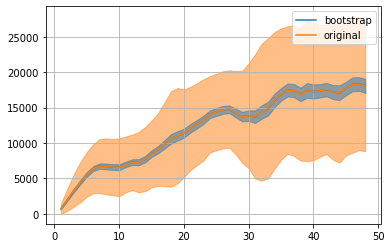

In [135]:
bootstraps, all_tracks = bootstrap_skills(tracks, skill)
fig, ax = plt.subplots(1,1)
bs_mean = bootstraps.groupby('hours since start').mean().reset_index()
at_mean = all_tracks.groupby('hours since start').mean().reset_index()
bs_std = bootstraps.groupby('hours since start').std().reset_index()
at_std = all_tracks.groupby('hours since start').std().reset_index()
ax.plot(bs_mean['hours since start'], 
        bs_mean[skill],
        label='bootstrap',
        color='C0')
ax.fill_between(bs_std['hours since start'], 
                bs_mean[skill] - bs_std[skill],
                bs_mean[skill] + bs_std[skill],
                color='C0', label='__nolegend__', alpha=0.5)
ax.plot(at_mean['hours since start'],
        at_mean[skill],
        label='original',
        color='C1')
ax.fill_between(at_std['hours since start'], 
                at_mean[skill] - at_std[skill],
                at_mean[skill] + at_std[skill],
                color='C1', label='__nolegend__', alpha=0.5,zorder=0)
ax.legend()
ax.grid()

Mean is pretty much unaffected by bootstrapping but the variability is significantly reduced with boostrapping.

Let's confirm the histogram shape.

/home/soontiensn/miniconda/envs/shapely/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:188: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


hours since start
1.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
2.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
3.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
4.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
5.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
6.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
7.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
8.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
9.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
10.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
11.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
12.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
13.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
14.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
15.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
16.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
17.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
18.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
19.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
20.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
21

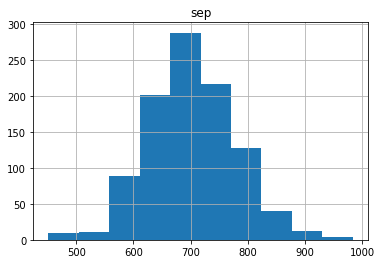

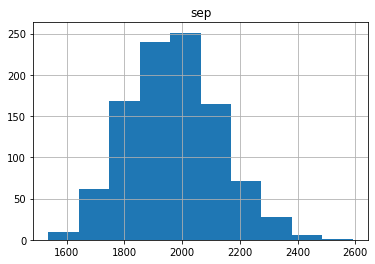

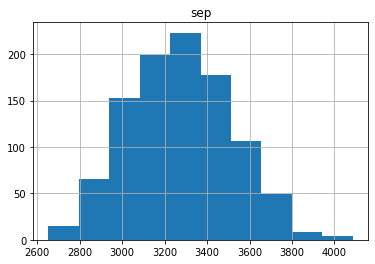

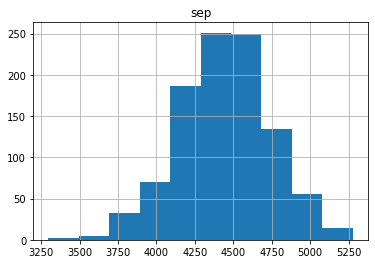

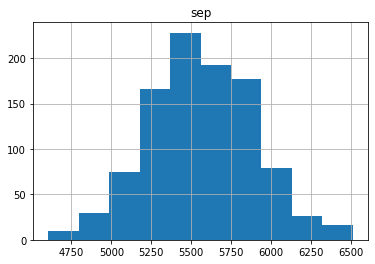

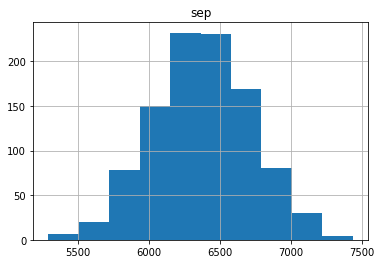

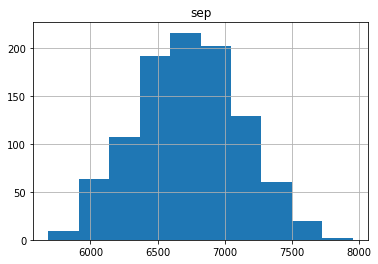

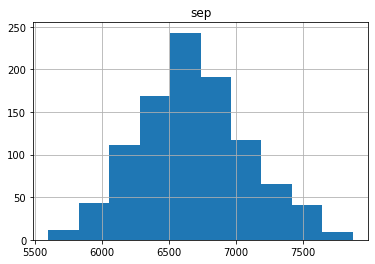

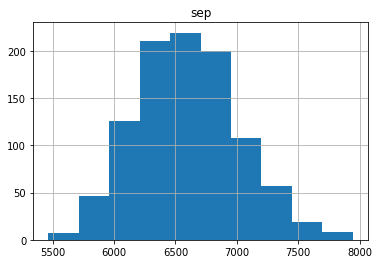

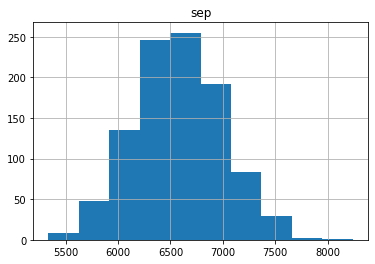

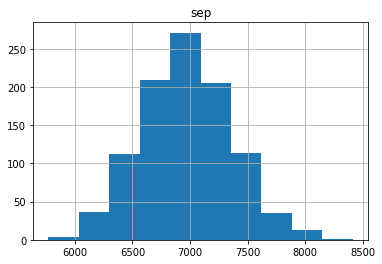

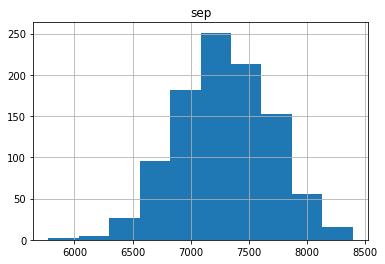

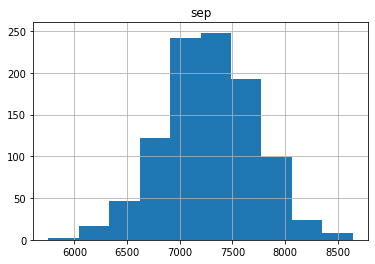

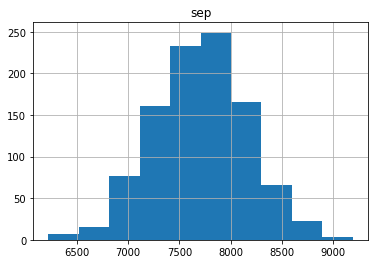

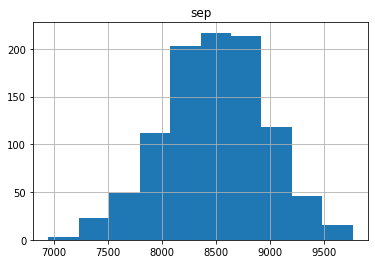

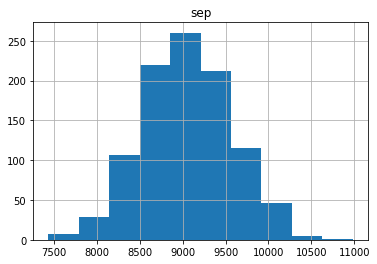

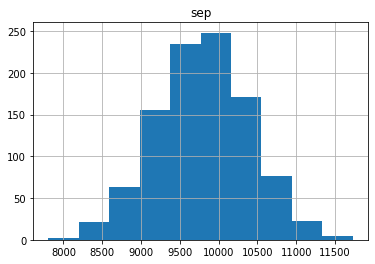

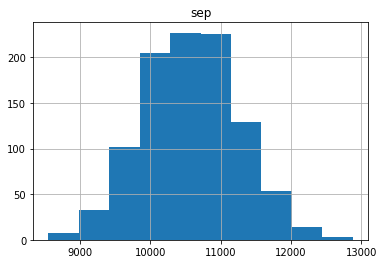

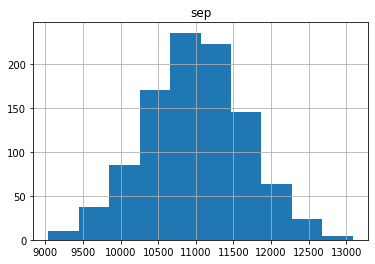

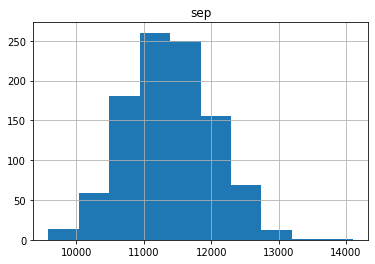

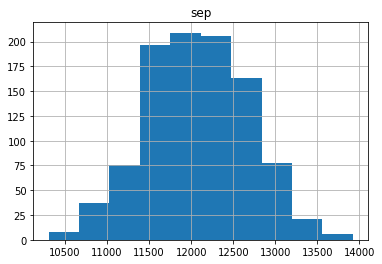

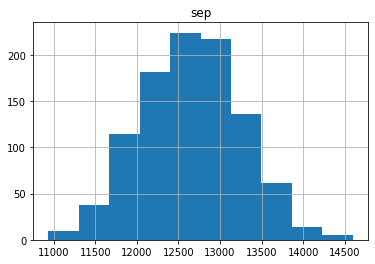

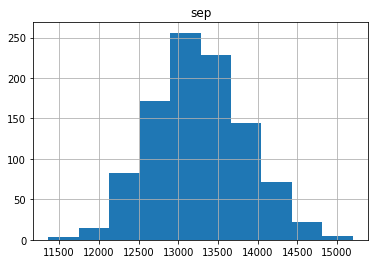

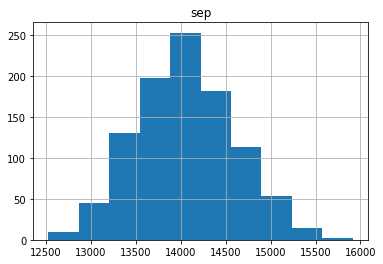

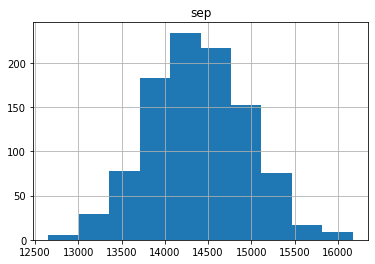

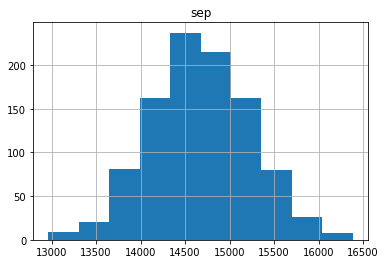

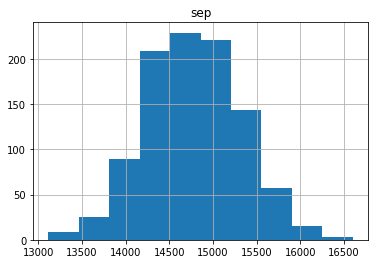

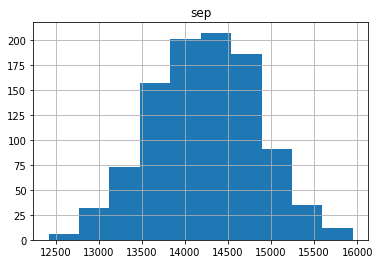

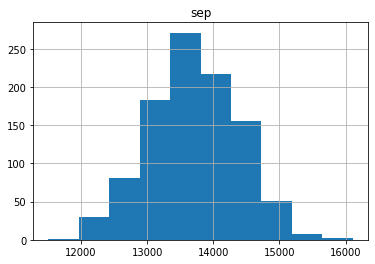

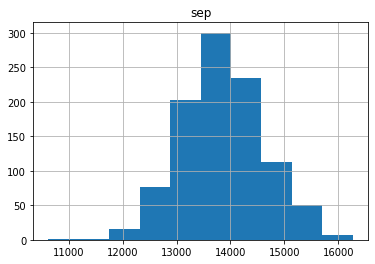

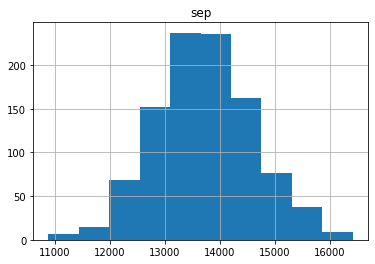

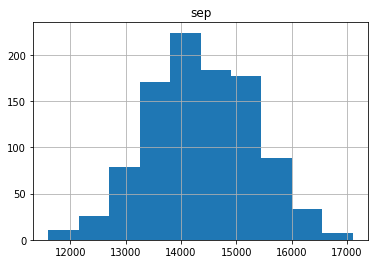

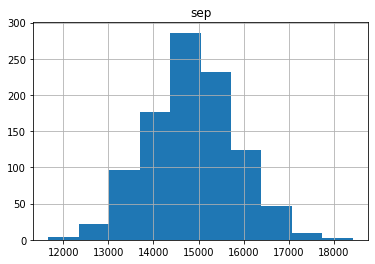

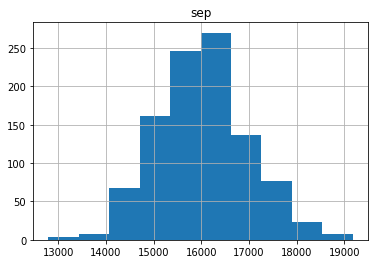

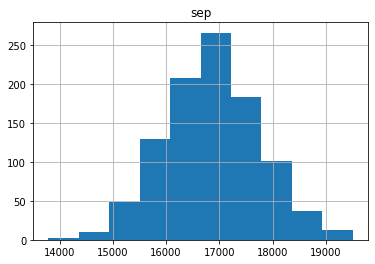

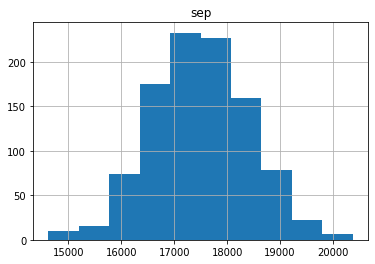

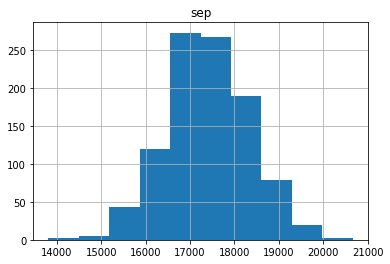

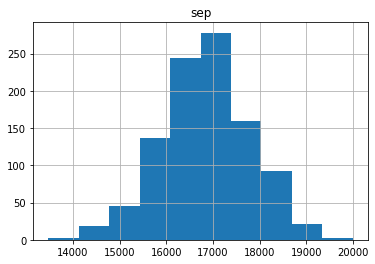

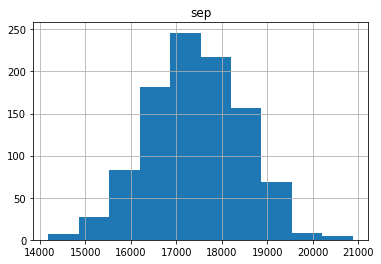

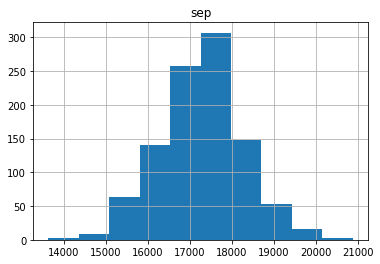

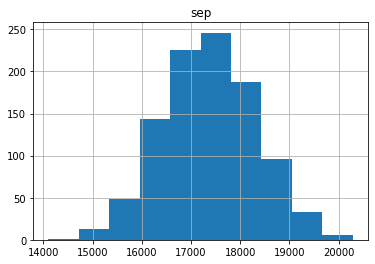

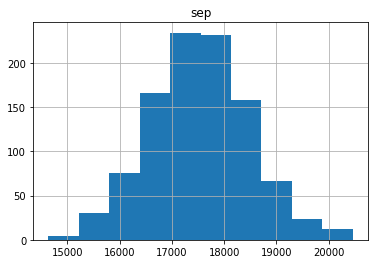

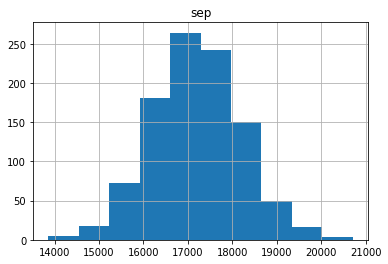

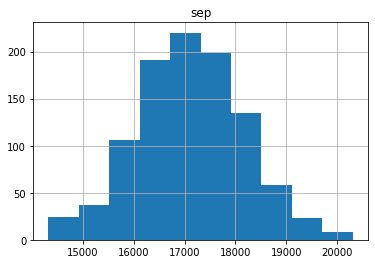

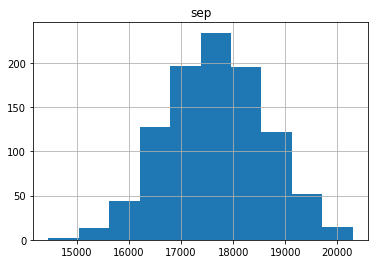

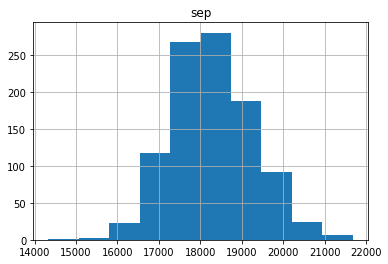

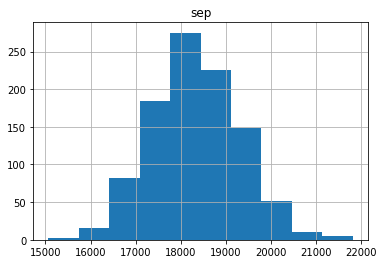

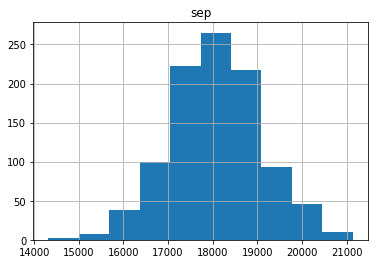

In [136]:
bootstraps.groupby('hours since start').hist()

hours since start
1.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
2.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
3.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
4.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
5.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
6.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
7.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
8.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
9.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
10.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
11.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
12.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
13.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
14.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
15.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
16.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
17.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
18.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
19.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
20.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
21

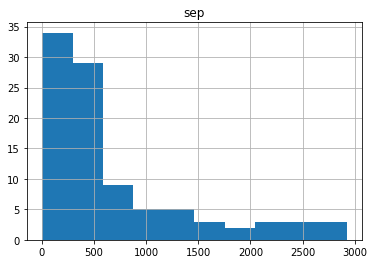

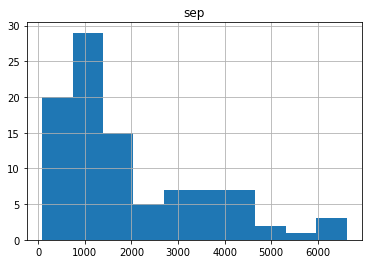

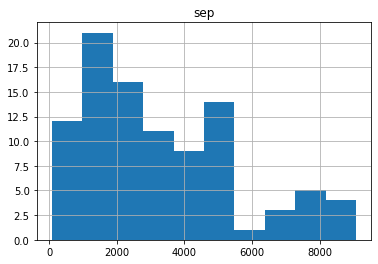

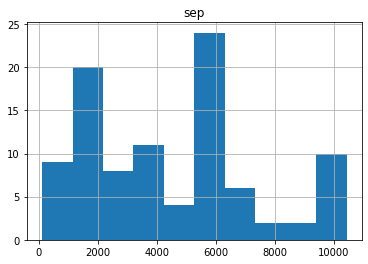

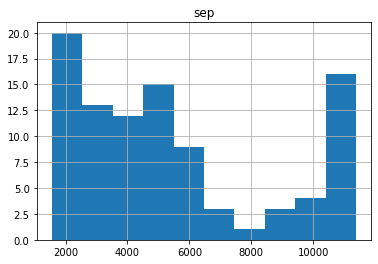

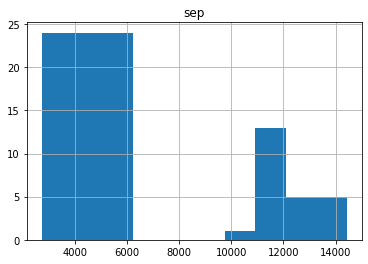

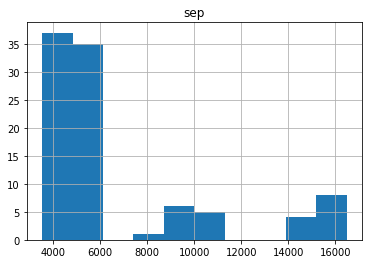

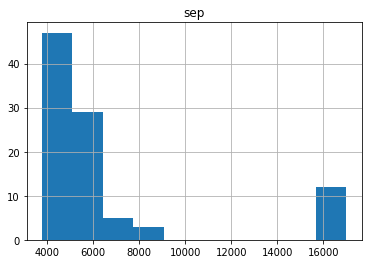

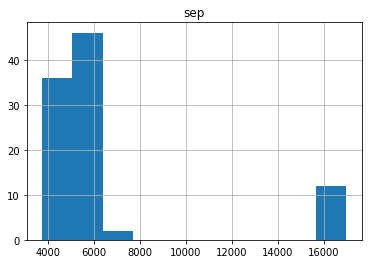

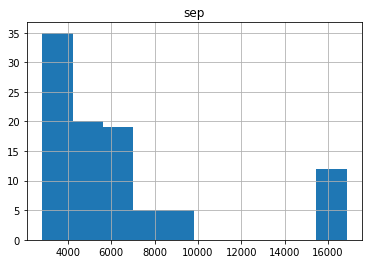

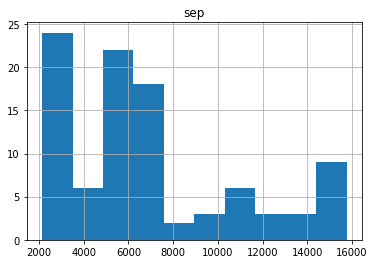

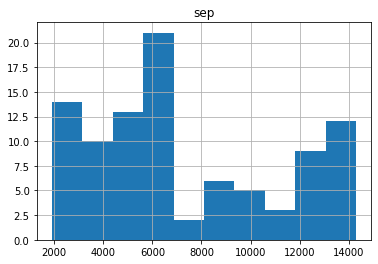

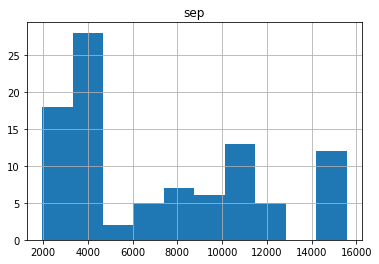

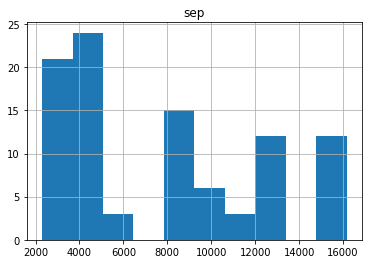

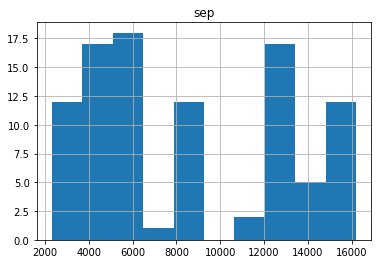

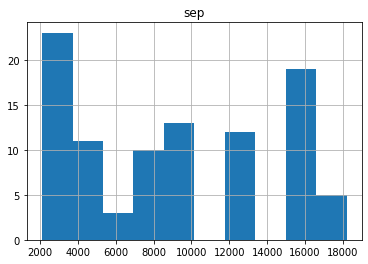

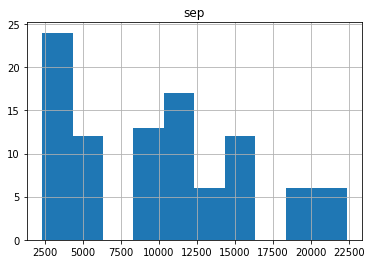

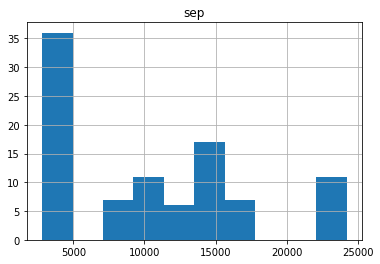

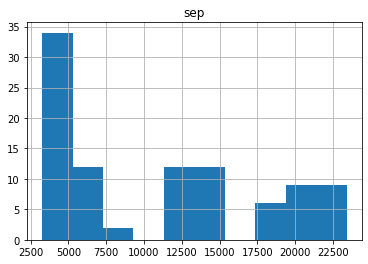

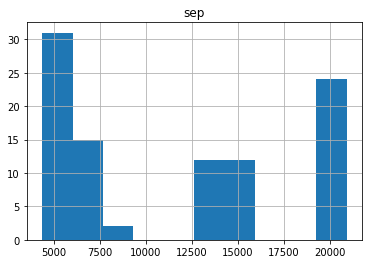

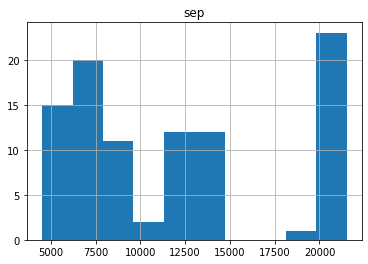

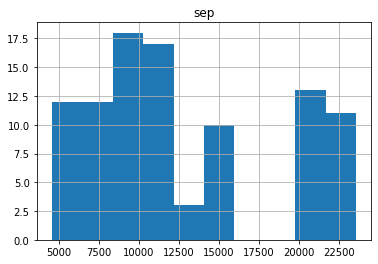

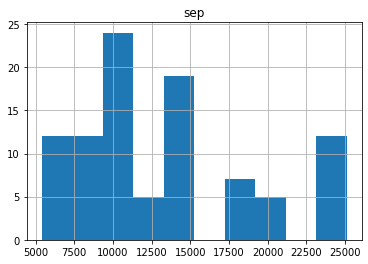

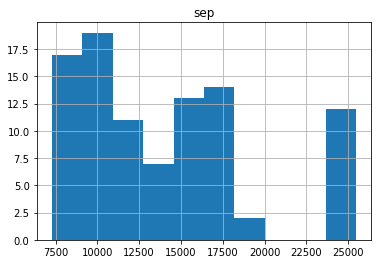

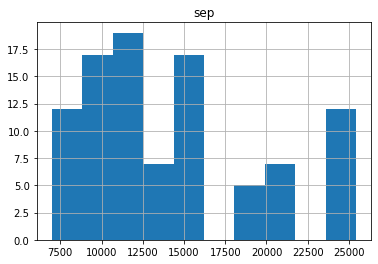

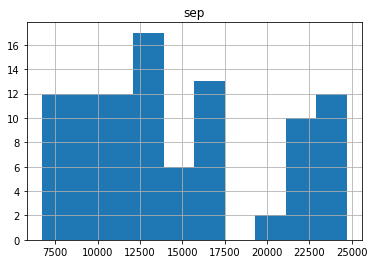

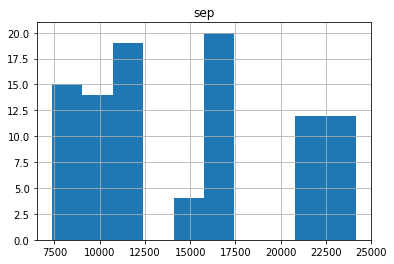

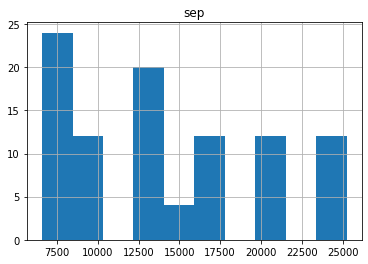

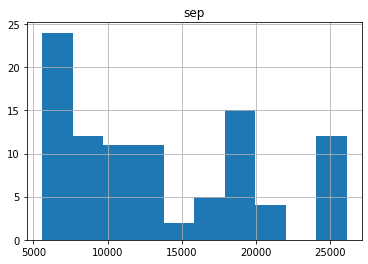

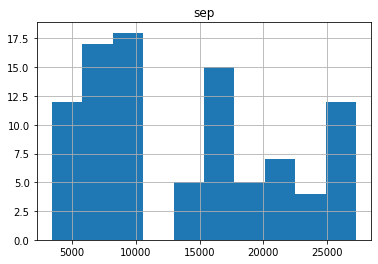

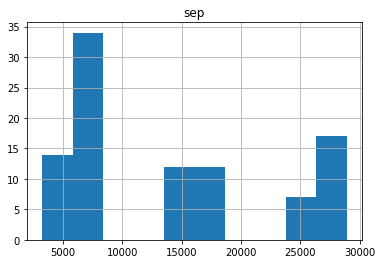

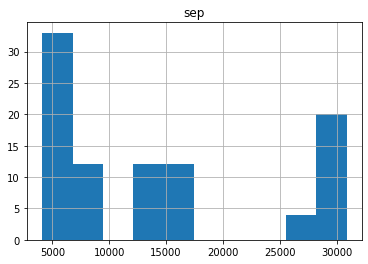

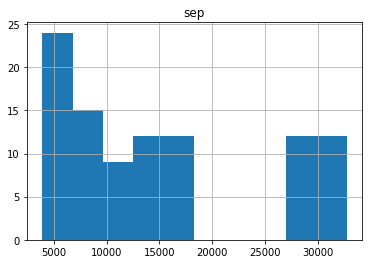

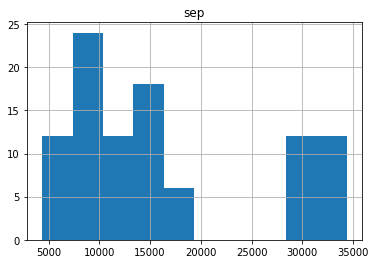

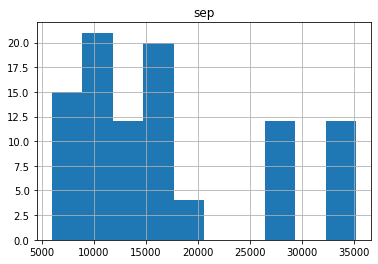

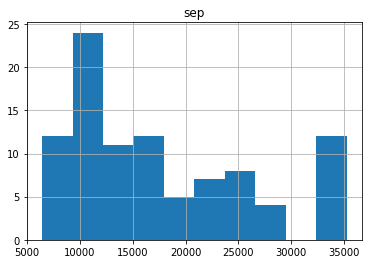

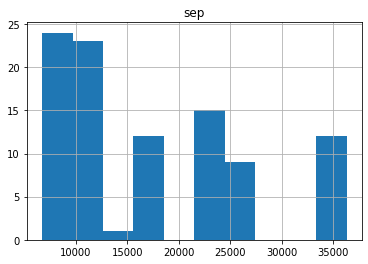

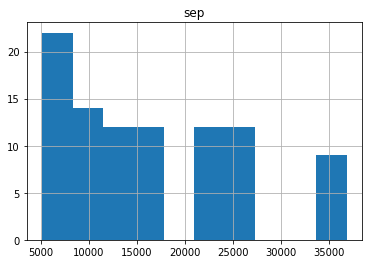

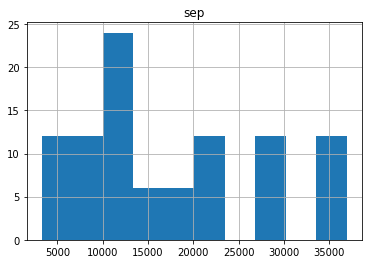

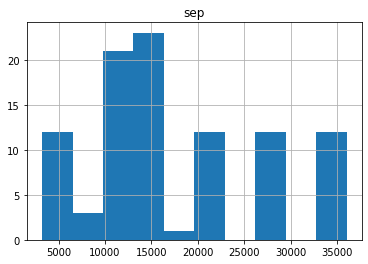

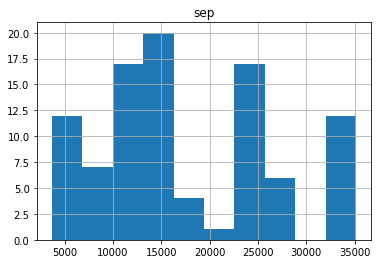

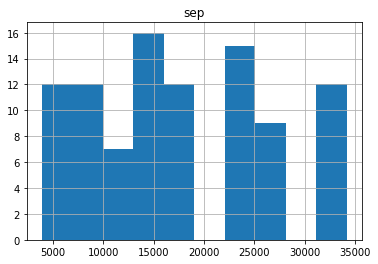

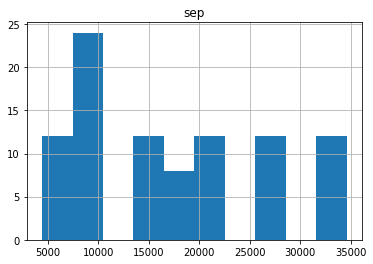

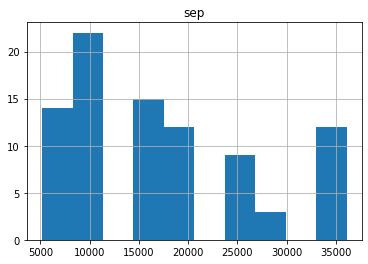

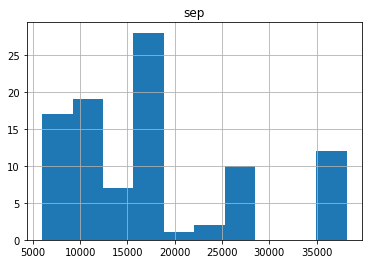

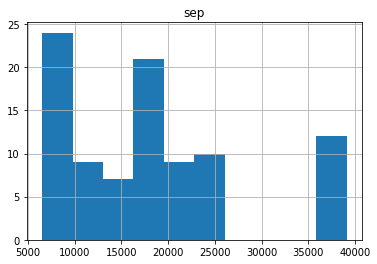

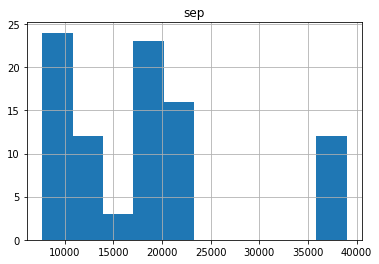

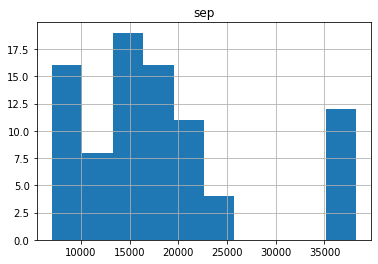

In [137]:
all_tracks.groupby('hours since start').hist()

Confirmed: bootstrapping method gives us a guassian distribution

Now apply to all drifters.

In [103]:
def bin_skills_all_drifters(ds_list, skill):
    """Bin the skill scores for an all drifters a model run.
    Scores are organized into hourly bins.
    
    Parameters
    ----------
    ds_list : list of xarray.Dataset
        The list datasets which should be averaged.
        
    skill : str
        The skill to be binned (e.g. sep, molcard, etc).
        
    Returns
    -------
    all_drifters_all_tracks : pandas.DataFrame
        A data frame that contains a list of scores for each track for all drifters organized
        into hourly bins.
    """
    all_drifters_all_tracks = pd.DataFrame()
    for ds in ds_list:
        drifter_tracks = bin_skills_individual_drifter(ds, skill)
        drifter_tracks['obs_buoyid'] = ds.obs_buoyid
        all_drifters_all_tracks = pd.concat([all_drifters_all_tracks, drifter_tracks])
    all_drifter_all_tracks = all_drifters_all_tracks.reset_index()
    all_drifter_all_tracks['hours since start'] = all_drifter_all_tracks.time_since_start.astype('timedelta64[h]')
    return all_drifters_all_tracks

In [138]:
all_drifters_all_tracks = bin_skills_all_drifters(dataset_per_set_all['SalishP01'], skill)

In [139]:
all_drifters_all_tracks

,index,time,sep,time_since_start,model_run,hours since start,obs_buoyid
0,0,2016-11-01 07:00:00,"[71.36101958815225, 148.3242347408981, 216.161...",0 days 01:00:00,0,1.0,wp2312547581D20161101
1,1,2016-11-01 08:00:00,"[654.8636190951893, 727.4627276829916, 802.830...",0 days 02:00:00,0,2.0,wp2312547581D20161101
2,2,2016-11-01 09:00:00,"[1403.5815157733225, 1468.1510154362675, 1556....",0 days 03:00:00,0,3.0,wp2312547581D20161101
3,3,2016-11-01 10:00:00,"[2193.2736384377354, 1950.7217584207162, 1668....",0 days 04:00:00,0,4.0,wp2312547581D20161101
4,4,2016-11-01 11:00:00,"[1556.3275339940647, 1806.0113321243941, 1872....",0 days 05:00:00,0,5.0,wp2312547581D20161101
5,5,2016-11-01 12:00:00,"[2927.8858789173846, 3066.0986327857163, 3181....",0 days 06:00:00,0,6.0,wp2312547581D20161101
6,6,2016-11-01 13:00:00,"[3774.7779208000006, 3706.151863818022, 3643.1...",0 days 07:00:00,0,7.0,wp2312547581D20161101
7,7,2016-11-01 14:00:00,"[3788.4919930139467, 3873.5629836307985, 3938....",0 days 08:00:00,0,8.0,wp2312547581D20161101
8,8,2016-11-01 15:00:00,"[4738.694342071844, 4813.194942480899, 4940.26...",0 days 09:00:00,0,9.0,wp2312547581D20161101
9,9,2016-11-01 16:00:00,"[6645.633916826056, 6912.363987410993, 7221.60...",0 days 10:00:00,0,10.0,wp2312547581D20161101


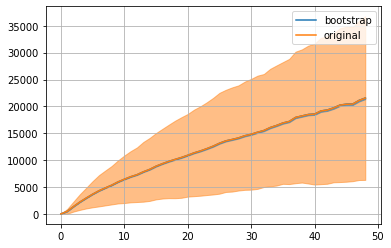

In [140]:
bootstraps, all_tracks = bootstrap_skills(all_drifters_all_tracks, skill)
fig, ax = plt.subplots(1,1)
bs_mean = bootstraps.groupby('hours since start').mean().reset_index()
at_mean = all_tracks.groupby('hours since start').mean().reset_index()
bs_std = bootstraps.groupby('hours since start').std().reset_index()
at_std = all_tracks.groupby('hours since start').std().reset_index()
ax.plot(bs_mean['hours since start'], 
        bs_mean[skill],
        label='bootstrap',
        color='C0')
ax.fill_between(bs_std['hours since start'], 
                bs_mean[skill] - bs_std[skill],
                bs_mean[skill] + bs_std[skill],
                color='C0', label='__nolegend__', alpha=0.5)
ax.plot(at_mean['hours since start'],
        at_mean[skill],
        label='original',
        color='C1')
ax.fill_between(at_std['hours since start'], 
                at_mean[skill] - at_std[skill],
                at_mean[skill] + at_std[skill],
                color='C1', label='__nolegend__', alpha=0.5,zorder=0)
ax.legend()
ax.grid()

/home/soontiensn/miniconda/envs/shapely/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:188: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


hours since start
0.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
1.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
2.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
3.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
4.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
5.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
6.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
7.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
8.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
9.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
10.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
11.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
12.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
13.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
14.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
15.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
16.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
17.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
18.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
19.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
20

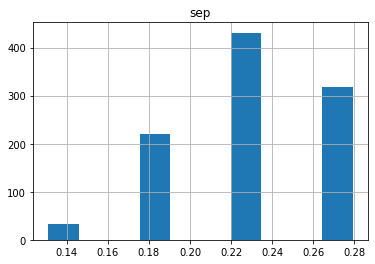

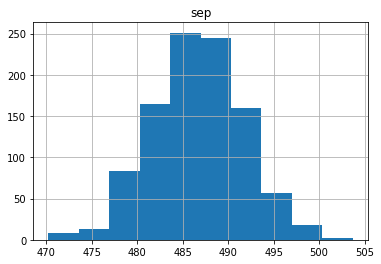

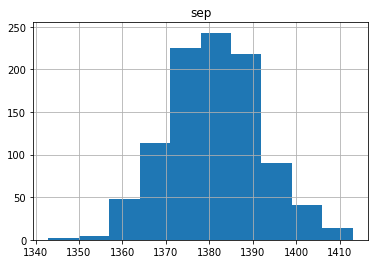

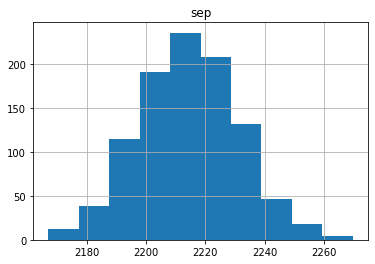

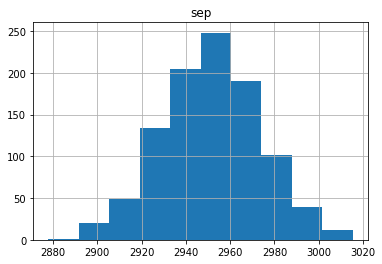

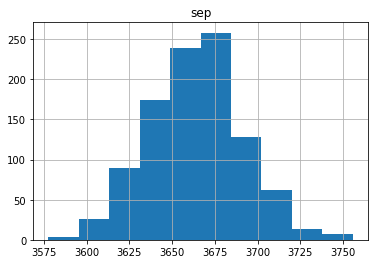

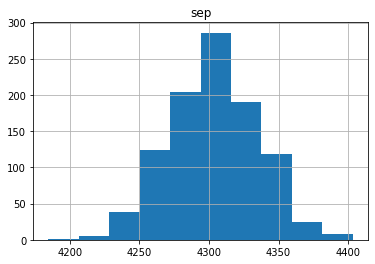

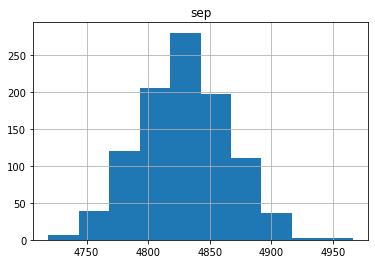

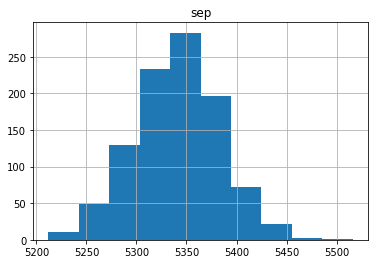

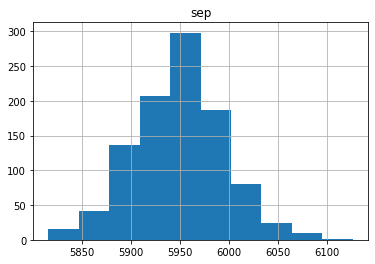

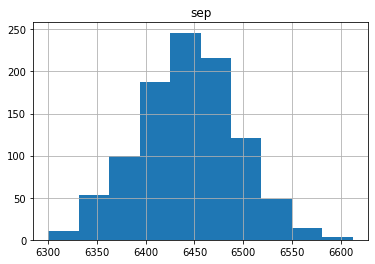

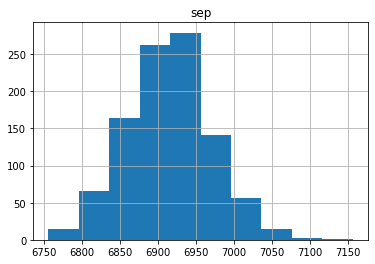

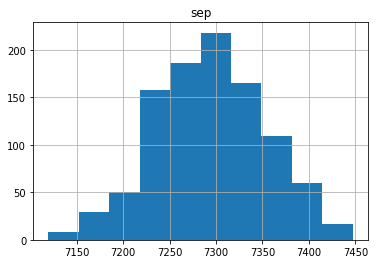

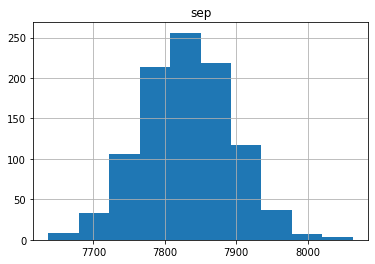

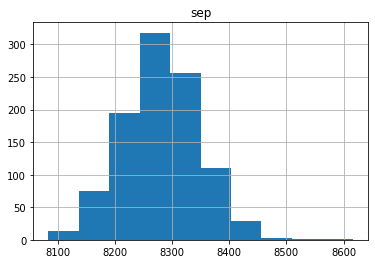

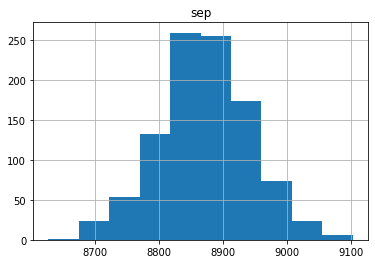

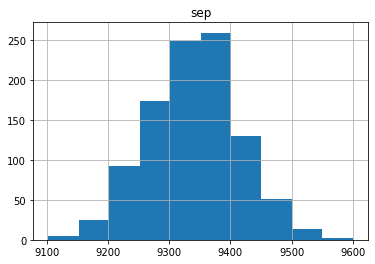

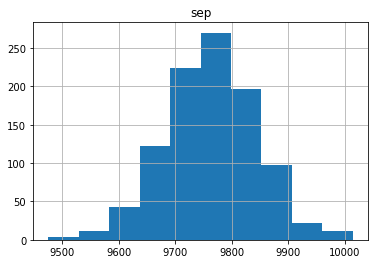

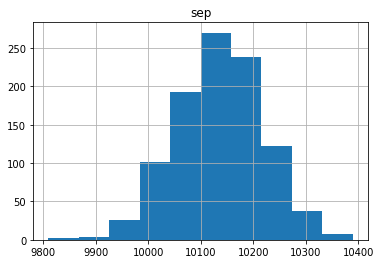

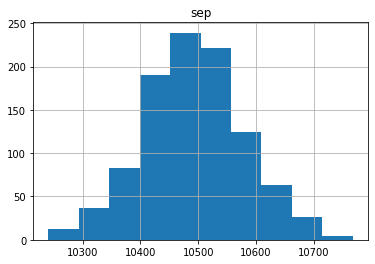

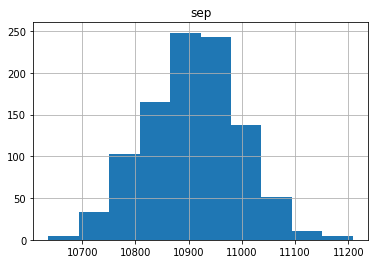

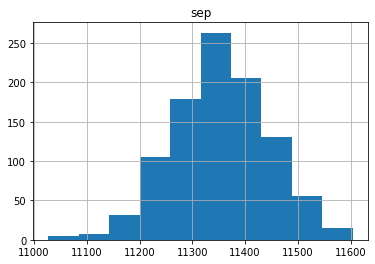

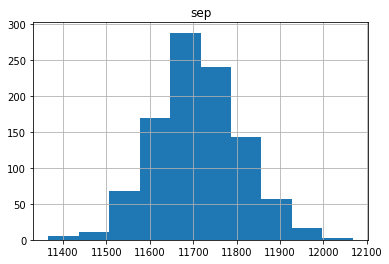

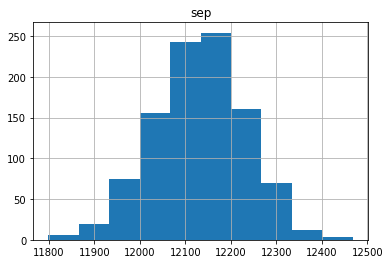

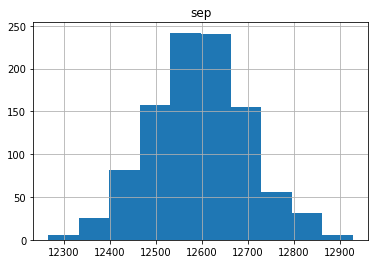

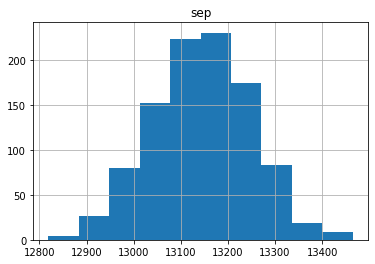

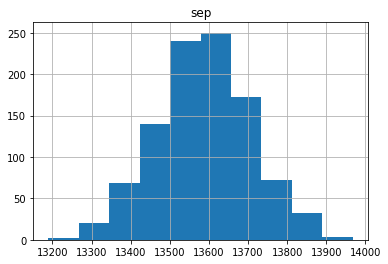

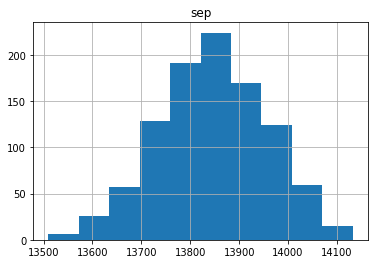

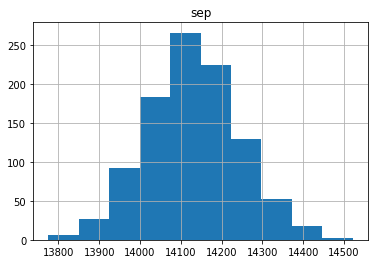

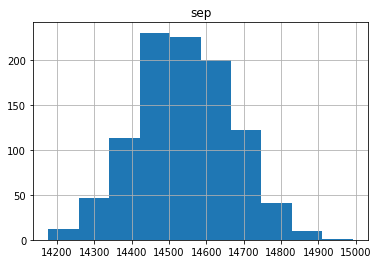

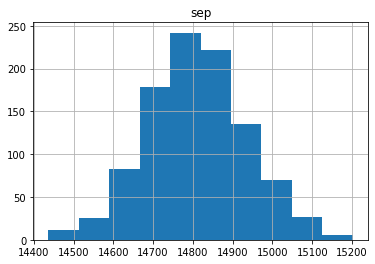

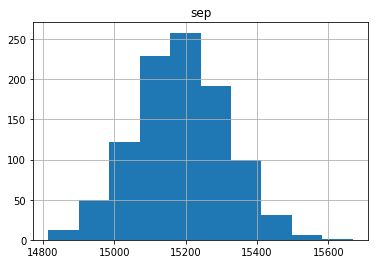

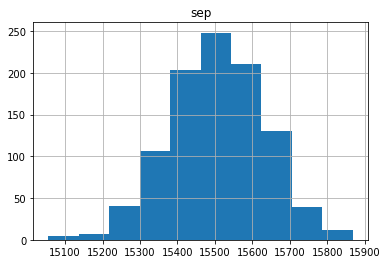

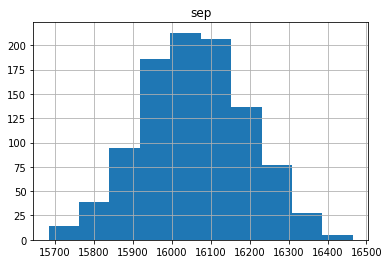

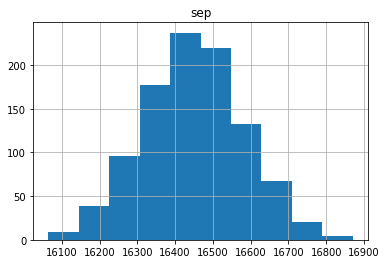

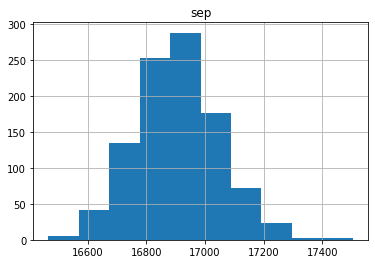

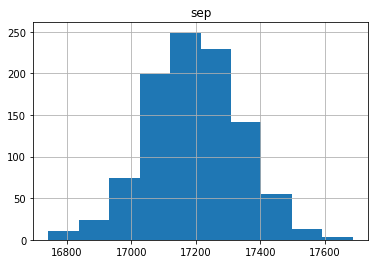

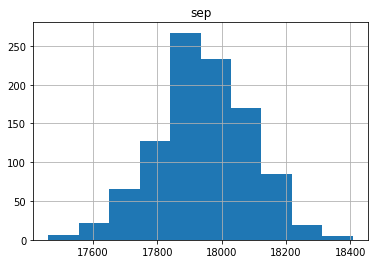

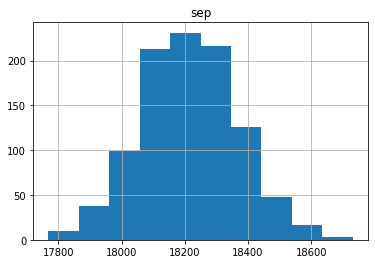

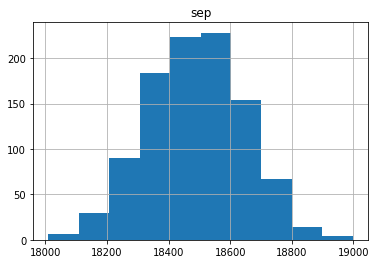

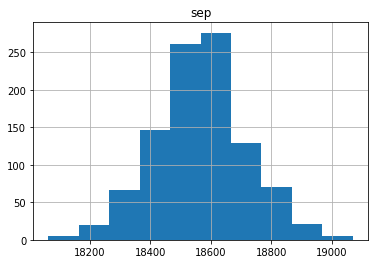

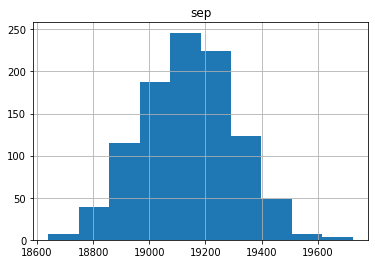

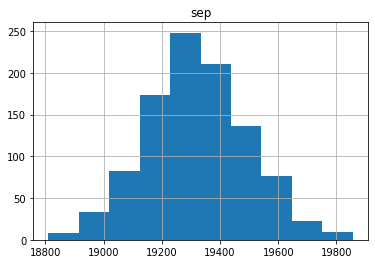

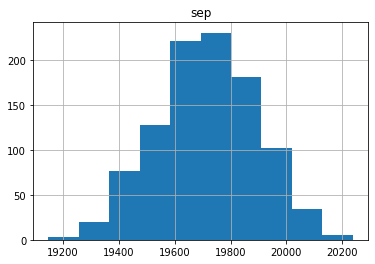

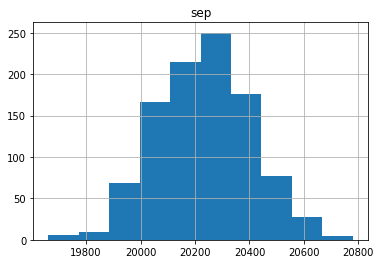

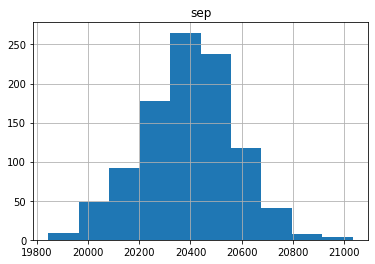

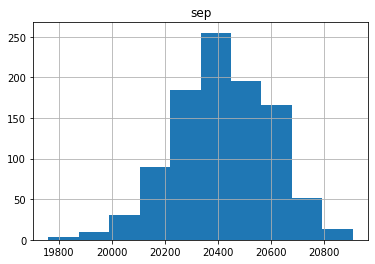

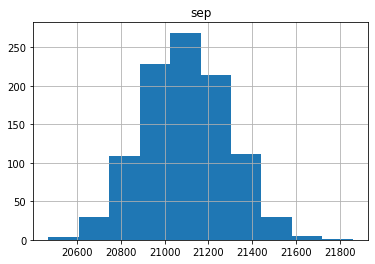

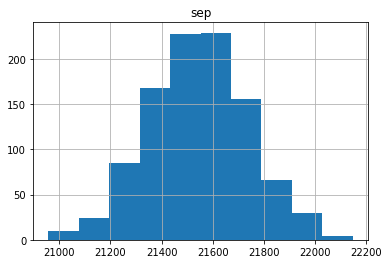

In [141]:
bootstraps.groupby('hours since start').hist()

hours since start
0.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
1.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
2.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
3.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
4.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
5.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
6.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
7.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
8.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
9.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
10.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
11.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
12.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
13.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
14.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
15.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
16.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
17.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
18.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
19.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
20

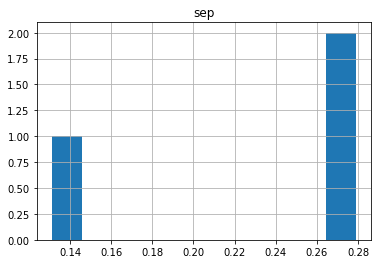

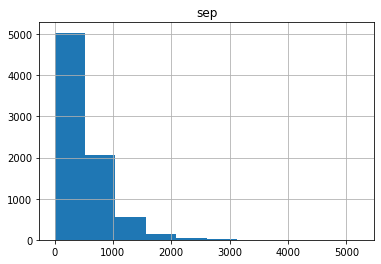

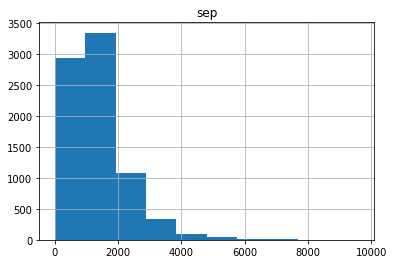

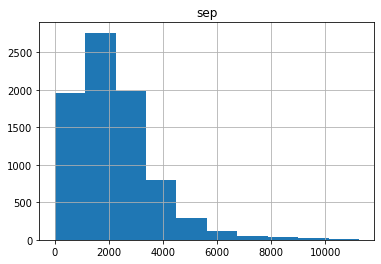

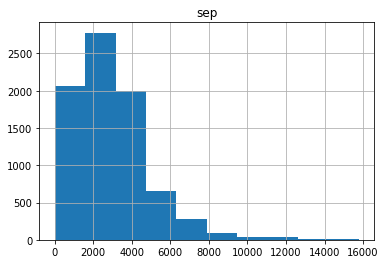

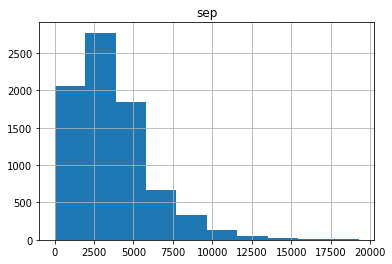

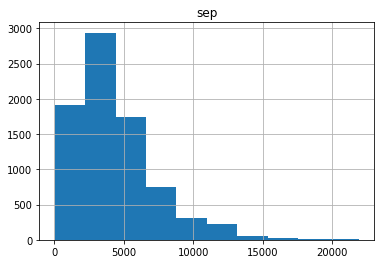

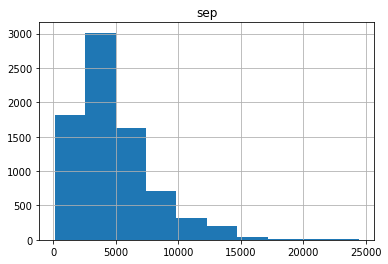

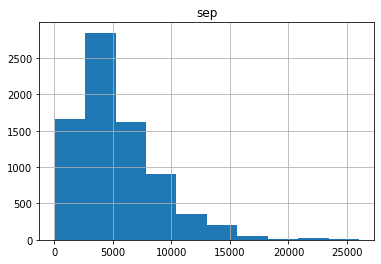

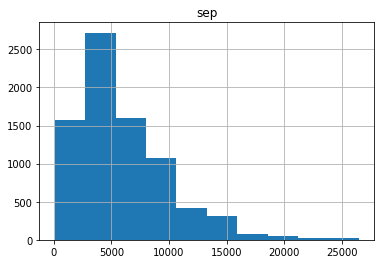

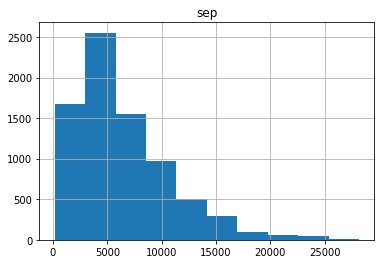

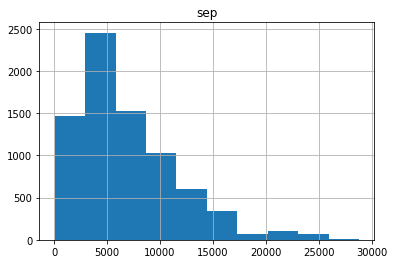

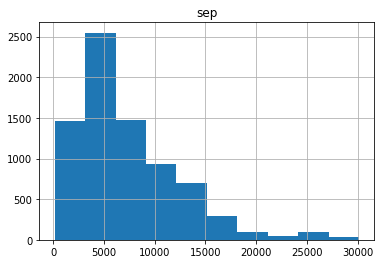

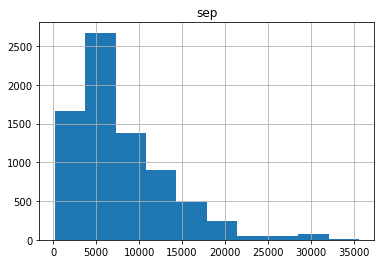

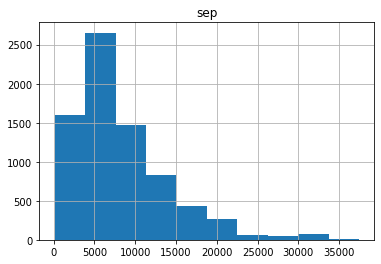

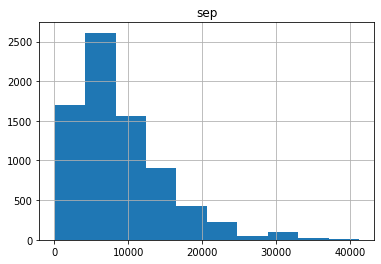

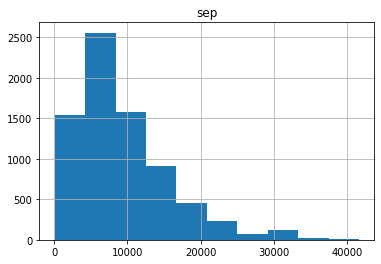

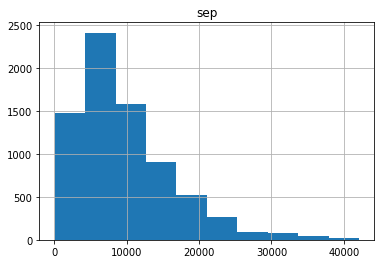

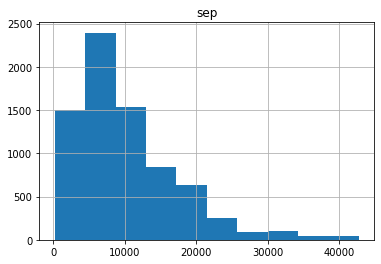

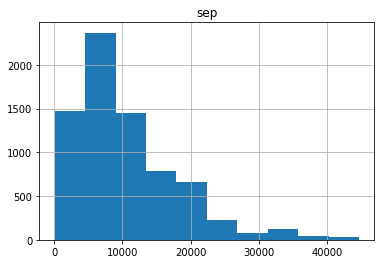

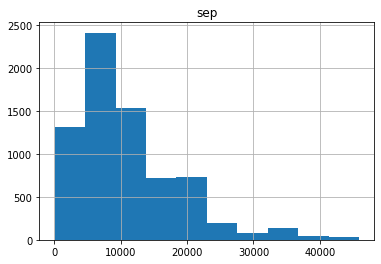

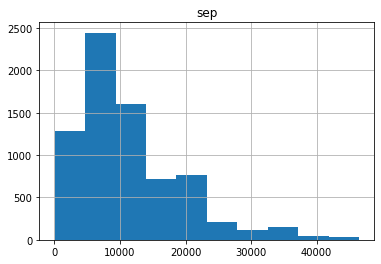

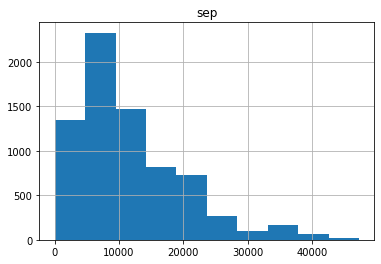

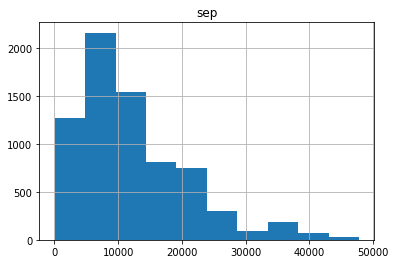

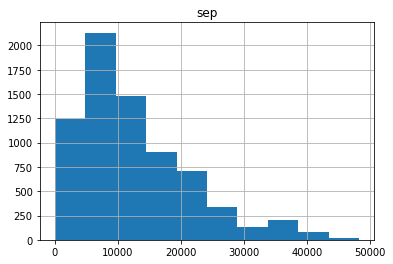

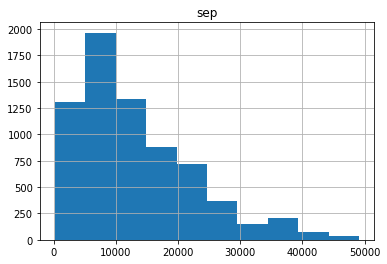

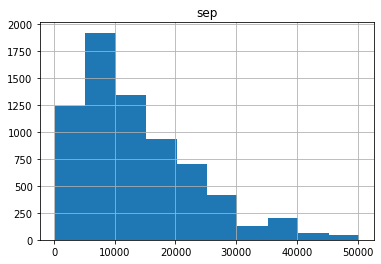

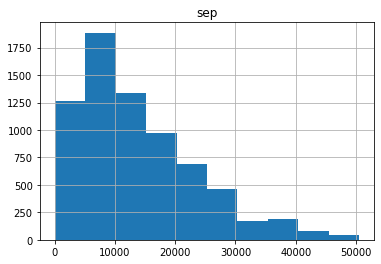

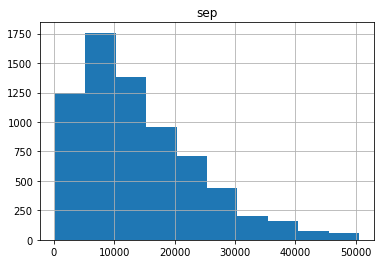

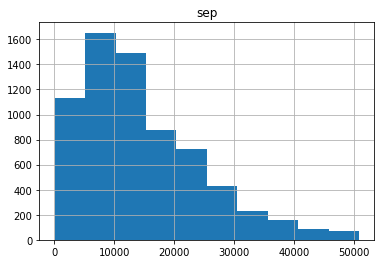

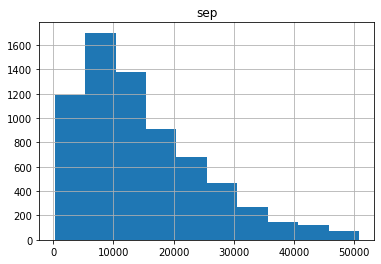

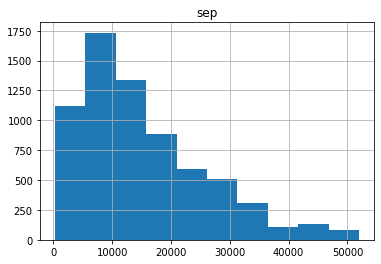

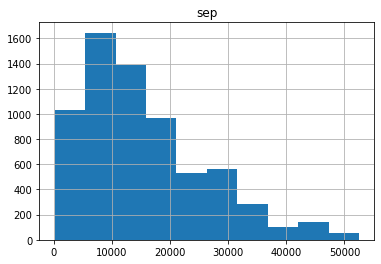

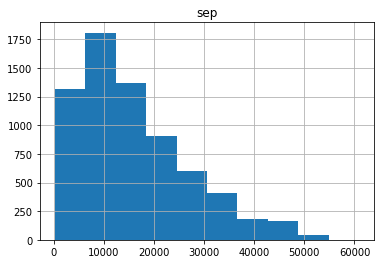

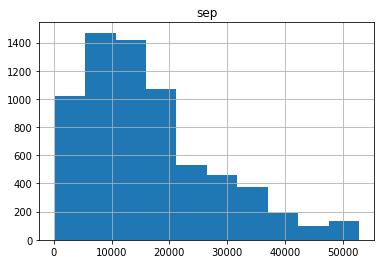

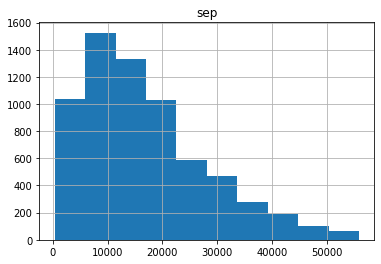

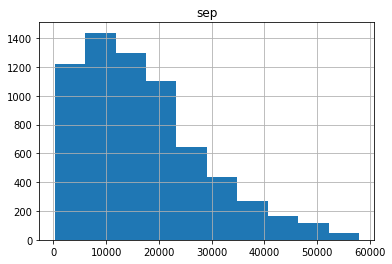

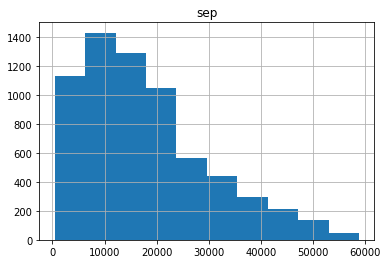

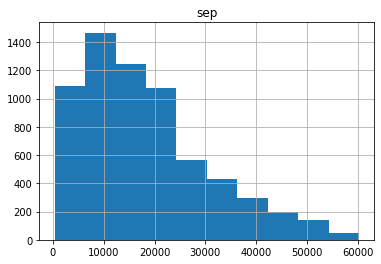

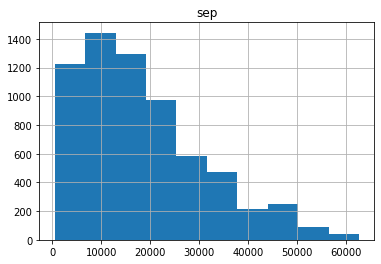

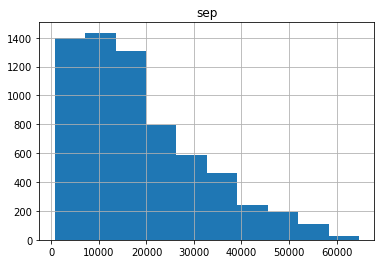

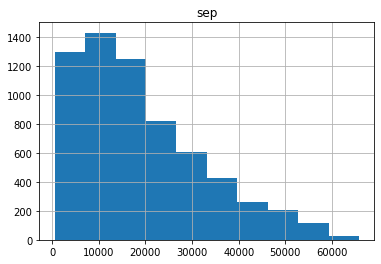

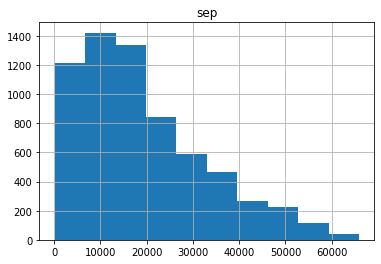

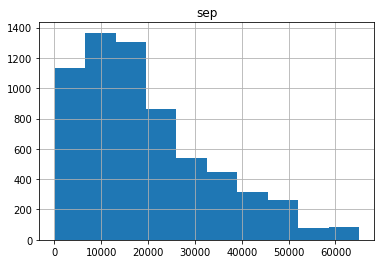

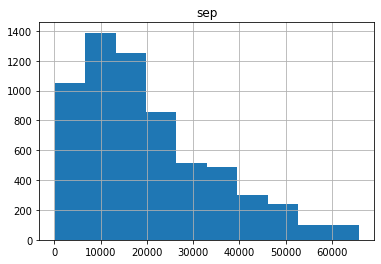

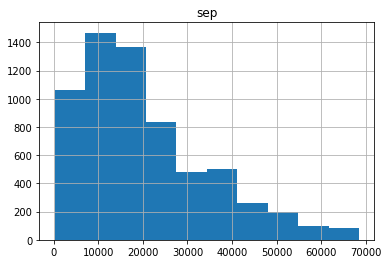

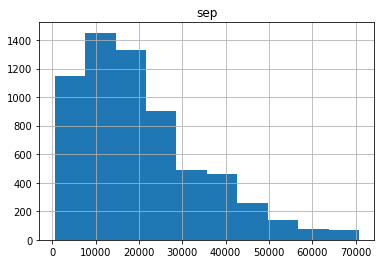

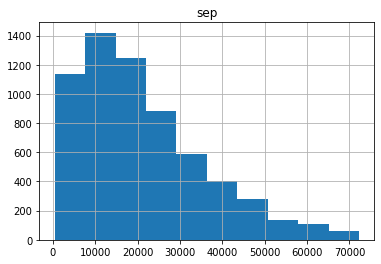

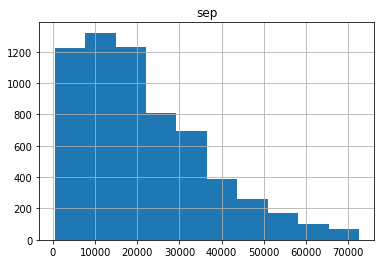

In [142]:
all_tracks.groupby('hours since start').hist()